In [1]:
import ufl
from ufl import  TrialFunction, TestFunction, FacetNormal, lhs, rhs,SpatialCoordinate

import dolfinx
from dolfinx import mesh, fem, io
from dolfinx.fem import FunctionSpace, VectorFunctionSpace, locate_dofs_geometrical, form
from dolfinx.fem.petsc import LinearProblem

from mpi4py import MPI
import petsc4py.PETSc
import numpy as np
import matplotlib.pyplot as plt


# Operators:
class Infix:

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)


dot = Infix(ufl.dot)
inner = Infix(ufl.inner)
from ufl import dx, ds, exp,sym,tr,sqrt
from ufl import nabla_div as div
from ufl import nabla_grad as grad
from ufl import as_vector as vector
from ufl import as_matrix as matrix

npor = Infix(np.logical_or)
npand = Infix(np.logical_and)

def I(func_like):
    """Create matrix Identity dimension of func_like

    Args:
        func_like (Function): Give geometric dimension

    Returns:
        Tensor: Identity
    """
    return ufl.Identity(func_like.geometric_dimension())

# Classes:


def Function(space, func=None):
    """Function on new space. Default create just Function on space

    Args:
        space (FunctionSpace): New space
        function (): Ufl_function, fem.Function, callable function, fem.Constant, constant

    Returns:
        fem.Function: Function
    """
    if func == None: return fem.Function(space)

    result = fem.Function(space)

    if not callable(func):
        expression = lambda x: x[0] * 0 + func

    elif hasattr(func, 'function_space'):
        expression = func

    elif hasattr(func, 'value'):
        expression = lambda x: x[0] * 0 + func.value

    elif hasattr(func, 'ufl_domain'):
        expression = fem.Expression(func, space.element.interpolation_points())
    else:
        expression = func

    result.interpolate(expression)
    return result


def Constant(space, const):
    """Constant on space

    Args:
        space (fem.FunctionSpace): Space
        const (auny number): Any number

    Returns:
        fem.function.Constant: Constant on space
    """
    return fem.Constant(space, petsc4py.PETSc.ScalarType(const))


def create_facet_markers(domain, bound_markers):
    """Mark facets under conditious

    Args:
        domain (Domain): Domain
        bound_markers (mark,python_function): List of mark and function
    
    Return:
        tags(mesh.meshtags): Marked facets
    """
    facet_indices, facet_markers = [], []
    for (marker, condition) in bound_markers:
        facets = mesh.locate_entities(
            domain,
            domain.topology.dim - 1,
            condition,
            )
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    facet_tags = mesh.meshtags(
        domain,
        domain.topology.dim - 1,
        facet_indices[sorted_facets],
        facet_markers[sorted_facets],
        )

    return facet_tags


def create_connectivity(domain):
    """Need to compute facets to Boundary value

    Args:
        domain (Mesh): Domain
    """
    domain.topology.create_connectivity(
        domain.topology.dim - 1,
        domain.topology.dim,
        )


def DirichletBC(space, func, combined_marker):
    """Create Dirichlet condition

    Args:
        space (fem.FunctionSpace): Function space
        func (fem.function): Function or Constant
        combined_marker (Any): One from next
        \nFunction - boundary marker function
        \nAll - all boundary
        \n(mesh.meshtags, marker) - list or tuple, marker of boundary from Marked_facets - mesh.meshtags
        
    Returns:
        condition (dirichletbc): Dirichlet condition
    """

    def get_exterior_facets():
        exterior_facets = mesh.exterior_facet_indices(domain.topology)
        return exterior_facets

    def all_dirichlet(dofs, func):
        if hasattr(func, 'function_space'):
            bc = fem.dirichletbc(dofs=dofs, value=func)
        else:
            bc = fem.dirichletbc(V=space, dofs=dofs, value=func)
        return bc

    domain = space.mesh

    if combined_marker == 'All':
        facets = get_exterior_facets()
        dofs = fem.locate_dofs_topological(
            space,
            domain.topology.dim - 1,
            facets,
            )

    elif type(combined_marker) == (tuple or list):
        marked_facets, marker = combined_marker
        facets = marked_facets.find(marker)
        dofs = fem.locate_dofs_topological(
            space,
            domain.topology.dim - 1,
            facets,
            )
    else:
        dofs = fem.locate_dofs_geometrical(space, marker=combined_marker)

    bc = all_dirichlet(dofs, func)

    return bc


# Post processing:
def errors_L(uS, uEx):
    """Compute error norm on boundary

    Args:
        uS (Function): Numeric solution
        uEx (Function): Exact or model solution

    Returns:
        List: L1 and L2 norms
    """
    domain = uS.function_space.mesh

    V_err = FunctionSpace(
        domain,
        ('CG', uS.function_space.element.space_dimension),
        )
    uEx = Function(V_err, uEx)
    L1_scalar = fem.assemble_scalar(form((uS-uEx) * dx))
    L2_scalar = fem.assemble_scalar(form((uS - uEx)**2 * dx))

    L1_err = np.abs(domain.comm.allreduce(L1_scalar, op=MPI.SUM))
    L2_err = np.sqrt(domain.comm.allreduce(L2_scalar, op=MPI.SUM))
    return (L1_err, L2_err)


def line_collision(domain, line_cord):
    """Generate points and cells of colliding domain and line

    Args:
        domain (mesh): Domain
        line_cord (array): 3D line contervertor of coordinates 

    Returns:
        Tuple: Collision points and collision cells
    """
    bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)

    cells_on_line = []
    points_on_line = []
    cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, line_cord.T)
    colliding_cells = dolfinx.geometry.compute_colliding_cells(
        domain, cell_candidates, line_cord.T
        )
    for i, point in enumerate(line_cord.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_line.append(point)
            cells_on_line.append(colliding_cells.links(i)[0])

    points_on_line = np.array(points_on_line, dtype=np.float64)

    return (points_on_line, cells_on_line)


def graph2D(fig, lists, natural_show=False, points_on=False):
    """Create graph from fem.Function

    Args:
        fig (plt.Figure): Figure
        lists (fem.Function , plt.Axes, str): List of (u, curent axes, title)
        method (bool): Graph method True = tripcolor, False = tricontourf
    """

    def data_construct(dofs, x_array):
        data = np.column_stack((dofs[:, 0:2], x_array))
        x_data = data[:, 0]
        y_data = data[:, 1]
        z_data = data[:, 2]
        return [x_data, y_data, z_data]

    for list in lists:
        fig, ax = plt.subplots()
        plt.close()
        u, ax, title = list
        dofs = u.function_space.tabulate_dof_coordinates()
        ax.set_title(title)
        data = data_construct(dofs, u.x.array)

        if points_on: ax.plot(data[0], data[1], 'o', markersize=2, color='grey')

        if natural_show:
            plot = ax.tripcolor(*data)
        else:
            try:
                levels = np.linspace(u.x.array.min(), u.x.array.max(), 10)
                plot = ax.tricontourf(
                    *data,
                    levels=levels,
                    )
            except:
                print(f'{title} - error')

        ax.set_aspect(1)
        fig.colorbar(plot, ax=ax)
    return

In [3]:
N = 20
domain = mesh.create_unit_square(
    MPI.COMM_WORLD,
    N,
    N,     # cell_type=mesh.CellType.quadrilateral,
    )
V = FunctionSpace(domain, ('CG', 1))
x, y = SpatialCoordinate(V)
n = FacetNormal(domain=domain)
dx = ufl.Measure('cell', subdomain_id='everywhere')

euEx = 1 + x**2 + 2 * y**2
uD = Function(V, x)
es = x
a = vector((x-x +1,x-x,x-x+3))

r = Constant(V, 10)
k = Constant(V, 1)

# g = -(n|dot|grad(euEx))
g = Function(V, 1)
f = -div(grad(euEx))
# f= Constant(V,0)

In [4]:
u, v = TrialFunction(V), TestFunction(V)
uEx = Function(V, euEx)
s = Function(V, uEx)

bound_markers = [
    (1, lambda x: np.isclose(x[0], 0)),
    (2, lambda x: np.isclose(x[0], 1)),
    (3, lambda x: np.isclose(x[1], 0)),
    (4, lambda x: np.isclose(x[1], 1)),
    ]
marked_facets = create_facet_markers(
    domain=domain,
    bound_markers=bound_markers,
    )
create_connectivity(domain=domain)
ds = ufl.Measure('ds', domain=domain, subdomain_data=marked_facets)

bcs = [
    DirichletBC(V, uD, (marked_facets, 1)),
    DirichletBC(V, uD, (marked_facets, 3)),
    ]

F = k * (grad(u)|dot|grad(v)) * dx - f*v*dx + g * v * ds(4)  + r*(u-s)*v*ds(3)

In [5]:
problem = LinearProblem(
    lhs(F),
    rhs(F),
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly", "pc_type": "lu"
        },
    )
uS = problem.solve()

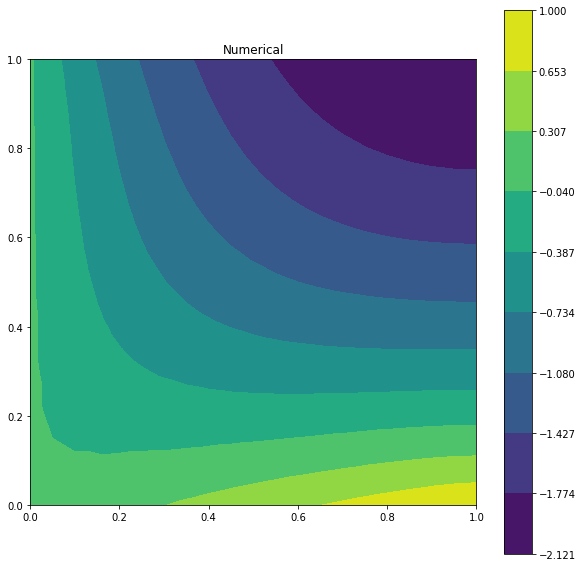

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

lis = [
    [uS, ax, 'Numerical'], 
    ]

graph2D(
    fig=fig,
    lists=lis,
    natural_show=False,
    # points_on=True,
    )


In [7]:
import shutil
try:
    shutil.rmtree('/home/VTK/3.4Poisson_Int_marker_Files')
except:
    print('Directory empty yet')

In [8]:
with io.VTKFile(
    domain.comm, '/home/VTK/3.4Poisson_Int_marker_Files/Poisson.pvd', 'w'
    ) as file:
    uS.name = 'Numeric'
    uEx.name = 'Exact'
    file.write_function([uS,uEx])

# Div grad problem

In [9]:
ufl_func = euEx
func = uEx
const = k
pyfunc = lambda x: x[1] + x[0]
pyconst = 6
list_of_types = [ufl_func, func, const, pyfunc, pyconst]


In [10]:
test1 = Function(V, lambda x: x[1] + x[0]**2)
test2 = Function(V, y + x**2)
test3 = Function(V, 1)


In [11]:
f2 = Function(V, div(grad(euEx)))
print(f2.x.array[0:6], f2.x.array[:-6:-1])


[6. 6. 6. 6. 6. 6.] [6. 6. 6. 6. 6.]


In [12]:
V2 = VectorFunctionSpace(domain, ('CG', 1))
f31 = Function(V2, grad(uS))
print(f31.x.array[0:6], f31.x.array[:-6:-1])


[ 1.         -6.24369215  1.         -6.88793906  0.3557531  -5.87643286] [ 0.         -5.88793906  0.         -5.88793906  0.        ]


In [13]:
f32 = Function(V, div(f31))
print(f32.x.array[0:6], f32.x.array[:-6:-1])


[11.15855914 20.23012394  7.44481832  8.14086396  8.13162434  5.365921  ] [ 0.          0.          0.         33.11506197 25.76987606]


In [14]:
f4 = Function(V, div(grad(uS)))
print(f4.x.array[0:6], f4.x.array[:-6:-1])


[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0.]


In [15]:
V

FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1, variant='equispaced'), dim=2, variant='equispaced'), 1), FiniteElement('Lagrange', triangle, 1))

In [16]:
print(type(k), type(f), type(uEx))


<class 'dolfinx.fem.function.Constant'> <class 'ufl.algebra.Product'> <class 'dolfinx.fem.function.Function'>


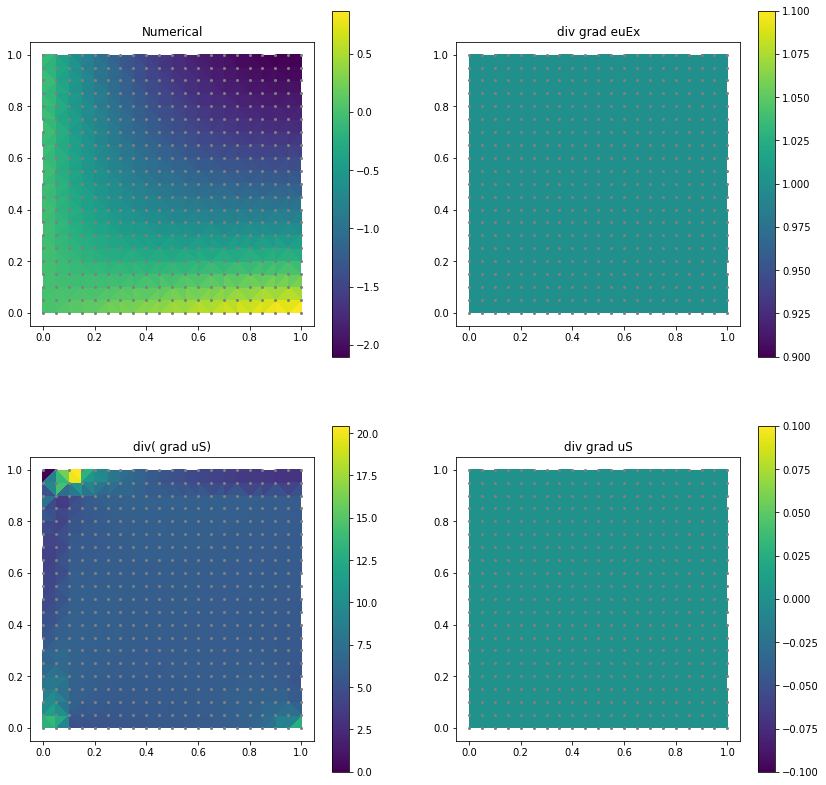

In [17]:
fig, ((ax, ax_donm), (ax_dif, ax2)) = plt.subplots(2, 2)
fig.set_size_inches(14, 14)

lis = [
    [uS, ax, 'Numerical'], [Function(V, k), ax_donm, 'div grad euEx'],
    [f32, ax_dif, 'div( grad uS)'], [f4, ax2, 'div grad uS']
    ]

graph2D(fig=fig, lists=lis, natural_show=True, points_on=True)

In [18]:
# with io.VTKFile(
#     domain.comm, '/home/VTK/3.4Poisson_Int_marker_Files/Poisson.pvd', 'w'
#     ) as file:
#     # file.write_mesh(domain)
#     uS.name = 'uS'
#     uEx.name = 'uEx'
#     f2.name = 'div grad euEx'
#     f31.name = 'grad uS'
#     f32.name = 'div( grad uS)'
#     f4.name = 'div grad uS'
#     file.write_function([uS, uEx, f2, f31, f32, f4])


# vector function problem

In [19]:
def Function1(space, func=None):
    """Function on new space. Without func just create a Function on space. 
    \nScalars - UFL_function, fem.Function, callable function, fem.Constant, constant
    \nVectors - UFL_vector, callable function which returns list of elements,
    Args:
        space (FunctionSpace): New space
        function (): 

    Returns:
        fem.Function: Function
    """
    def fill(x):
        res =np.zeros_like(x)
        # for i in range(len(res)):
        res[0].fill(func[0])
        return res
    
    result = fem.Function(space)
    
    if func == None: 
        return result
    # list
    elif not callable(func): 
        expression = fill
    # Function
    elif hasattr(func, 'function_space'): 
        expression = func
    # Constant
    elif hasattr(func, 'value'): 
        func= func.value
        expression = fill
    # ufl function
    elif hasattr(func, 'ufl_domain'): 
        expression = fem.Expression(func, space.element.interpolation_points())
    # python function
    else:
        expression = func 

    result.interpolate(expression)
    return result

In [20]:
a= np.ones((1,799))
a.shape

(1, 799)

In [21]:
f= Function(V)
f.interpolate(a)

In [22]:
b = np.array([
    [1, 2, 3],
    [1, 2, 4],
    ])
len(b.shape)

2